In [1]:

import pandas as pd

from utils.io import yaml_to_dict,dict_to_yaml

from cleanco import basename

import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict

# from projects.lobbying.postproc import terms_present
import matplotlib.colors as mc

import warnings

warnings.filterwarnings("ignore")
%load_ext jupyter_black

In [5]:
def invert_sector_dict(sectors_path) -> Dict[str, str]:
    """reads in the sector assignment yaml to dict; inverts dict s.t. each company is a key"""
    sector_assignments = yaml_to_dict(sectors_path)

    all_companies = []
    for _, value in sector_assignments.items():
        all_companies = all_companies + value
    # print(all_companies)

    company_sector_dict = {}
    for k, vv in sector_assignments.items():
        for v in vv:
            company_sector_dict = company_sector_dict | {v: k}

    return company_sector_dict

In [6]:
df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/oct4_compiled_filings.csv")
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)

In [ ]:
for i in df.client_rename.unique():
    if i not in inverted_sector_dict.keys():
        print(f"{i}")

In [3]:
df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/oct4_compiled_filings.csv")

In [39]:
df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/oct7_postprocessed_filings.csv")

In [29]:
portland_replace_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/company_name_replacements.yml"
)

df["client_rename"] = [
    portland_replace_dict[x] if x in list(portland_replace_dict.keys()) else r
    for x, r in zip(df.client_name, df.client_rename)
]
df["sector"] = [inverted_sector_dict[x] for x in df["client_rename"]]
sectors_dict = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
inverted_sector_dict = invert_sector_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
companies = [c.rstrip().lstrip() for c in list(inverted_sector_dict.keys())]
not_assigned = sorted(list(set(df.client_rename.unique()) - set(companies)))
for c in not_assigned:
    # for c in ["FMC"]:
    names = list(df.loc[df.client_rename == c].client_name.unique())
    for n in names:
        print(f"{n}: {c}")
    # descriptions = list(df.loc[df.client_rename == c].clean_description.unique())
    # for d in descriptions:
    #    print(d)
    print("")

In [8]:
df.clean_description = df.clean_description.fillna("")
df["ccs"] = [
    1
    if (
        (" ccs" in x.lower())
        | (" ccus" in x.lower())
        | ("capture and utilization" in x.lower())
        | ("carbon capture storage" in x.lower())
        | ("carbon capture and storage" in x.lower())
        | ("co2 capture and sequestration" in x.lower())
        | ("co2 capture sequestration" in x.lower())
        | ("capture transport and storage" in x.lower())
        | ("capture and storage of carbon" in x.lower())
        | ("capture and sequestration of carbon" in x.lower())
        | ("capture sequestration of carbon" in x.lower())
        | ("carbon capture and sequestration" in x.lower())
        | ("carbon capture sequestration" in x.lower())
        | ("co2 capture storage" in x.lower())
        | ("clean hydrogen" in x.lower())
        | ("blue hydrogen" in x.lower())
        | ("beccs" in x.lower())
        | ("hydrogen hub" in x.lower())
        | ("carbon dioxide pipeline" in x.lower())
        | ("co2 pipeline" in x.lower())
        | ("class vi" in x.lower())
    )
    else 0
    for x in df.clean_description
]
df["bio"] = [
    1
    if (
        ("biofuel" in x.lower())
        | ("biomass" in x.lower())
        | ("bioenergy" in x.lower())
        | ("waste to energy" in x.lower())
        | ("wastetoenergy" in x.lower())
        | ("sustainable aviation" in x.lower())
        | ("biodiesel" in x.lower())
    )
    else 0
    for x in df.clean_description
]
df.ccs.value_counts()

ccs
0    217087
1      5057
Name: count, dtype: int64

In [31]:
df.loc[df.very_likely_ccs == 1].sector.value_counts()

sector
investor owned utilities                   2610
oil and gas                                1723
ccs                                        1355
chemicals, refining, and plastics          1015
coal                                        715
biofuels                                    573
municipal and cooperative utilities         534
pipelines                                   533
clean hydrogen                              460
environmental                               439
labor union                                 408
energy technology                           251
renewable energy                            247
food and agriculture                        239
land transit                                236
cement                                      232
higher education                            213
oilfield services                           200
independent power producers                 198
paper products                              196
finance                          

In [15]:
for c in sorted(
    list(set((df.loc[(df.sector == "higher education")].client_rename.unique())))
):
    print(f"- {c}")

- 1890 UNIVERSITIES
- ALABAMA AM UNIV RESEARCH INSTITUTE AAMURI
- AMERICAN ASSOCIATION OF COMMUNITY COLLEGES
- AMERICAN PUBLIC UNIVERSITY SYSTEM
- AMERICAN UNIVERSITY OF BEIRUT
- ARIZONA STATE UNIVERSITY
- ARKANSAS STATE UNIVERSITY
- ASSOCIATED UNIVERSITIES
- ASSOCIATION OF AMERICAN UNIVERSITIES
- ASSOCIATION OF COMMUNITY COLLEGE TRUSTEES
- ASSOCIATION OF JESUIT COLLEGES AND UNIVERSITIES
- ASSOCIATION OF PRIVATE SECTOR COLLEGES AND UNIVERSITIES
- ASSOCIATION OF PROPRIETY COLLEGES
- ASSOCIATION OF PUBLIC AND LANDGRANT UNIVERSITIES APLU
- ASSOCIATION OF UNIVERSITIES FOR RESEARCH IN ASTRONOMY
- BAYLOR UNIVERSITY
- BECKER COLLEGE
- BENNETT COLLEGE
- BISMARCK STATE COLLEGE
- BOSTON COLLEGE
- BOSTON UNIVERSITY
- BOWLING GREEN STATE UNIVERSITY
- BROWN UNIVERSITY
- CALIFORNIA INSTITUTE OF TECHNOLOGY
- CALIFORNIA STATE UNIVERSITY
- CARNEGIE MELLON UNIVERSITY
- CASE WESTERN RESERVE UNIVERSITY
- CITY UNIVERSITY OF NEW YORK
- CLEMSON UNIVERSITY
- COALITION OF URBAN SERVING UNIVERSITIES
- COLORADO 

In [16]:
for c in sorted(
    list(
        df.loc[
            (df.ccs == 1) & (df.sector == "higher education") & (df.sector != "ccs")
        ].client_rename.unique()
    )
):
    print(f"- {c}")

- ARIZONA STATE UNIVERSITY
- CALIFORNIA INSTITUTE OF TECHNOLOGY
- CARNEGIE MELLON UNIVERSITY
- GEORGIA INSTITUTE OF TECHNOLOGY
- NEW MEXICO STATE UNIVERSITY
- UNIVERSITY OF CALIFORNIA
- UNIVERSITY OF KENTUCKY
- UNIVERSITY OF MICHIGAN
- UNIVERSITY OF TEXAS
- YALE UNIVERSITY


In [ ]:
df.loc[
    (df.client_rename == "AMERICANS FOR TAX REFORM") & (df.ccs == 1)
].clean_description.values

In [ ]:
for i in list(
    df.loc[df.client_rename == "RENEWABLE ENERGY GROUP"].client_name.unique()
):
    print(f"{i}: ")

In [93]:
import os


def rename_files(directory):
    # Iterate over all files in the specified directory
    for filename in os.listdir(directory):
        # Check if the file is a CSV file
        if filename.endswith(".csv"):
            # Construct the old file path
            old_file_path = os.path.join(directory, filename)

            # Construct the new file name with 'latest_' prefix
            new_file_name = "latest_" + filename

            # Construct the new file path
            new_file_path = os.path.join(directory, new_file_name)

            # Rename the file
            os.rename(old_file_path, new_file_path)
            print(f"Renamed: {filename} to {new_file_name}")

In [ ]:
tmp = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/sectors_updated.yml"
)
he = tmp["chemicals, refining, and plastics"]
he = sorted(list(set(he)))
for h in he:
    print(f"- {h}")

In [ ]:
for c in not_assigned:
    original_names = df.loc[df.client_rename == c].client_name.unique()
    for n in original_names:
        print(f"{n}: {c}")

In [188]:
# df.to_csv("~/Desktop/postprocessed_ccs.csv")

df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/oct8_postprocessed_filings.csv")
df[
    [
        "ccs_company",
        "ccs_description",
        "ccs_bills",
        "ccs_bills_number_only",
        "bills_with_ccs_terms",
        "definitely_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "potentially_ccs",
    ]
].sum()

ccs_company               1315
ccs_description           9418
ccs_bills                 3435
ccs_bills_number_only     3830
bills_with_ccs_terms      3575
definitely_ccs           13605
very_likely_ccs          14293
likely_ccs               14733
potentially_ccs          26496
dtype: int64

In [45]:
maybe_df = df.loc[
    (df.contains_ccs_description == 1)
    & (df.ccs_bills == 0)
    & (df.ccs_bills_number_only == 0)
    & (df.ccs_company == 0)
    & (df.clean_h2_description == 0)
    & (df.clean_h2_company == 0)
]


maybe_df["obvi"] = [
    1
    if (
        (
            ("hydrogen" in x.lower())
            and (
                s
                in [
                    "clean hydrogen",
                    "oil and gas",
                    "pipelines",
                    "oilfield services",
                    "chemicals, refining, and plastics",
                ]
            )
        )
        | ("ccs" in x.lower())
        | ("capture co2" in x.lower())
        | ("carbon capute" in x.lower())
        | ("carbon capture" in x.lower())
        | ("carboncapture" in x.lower())
        | ("capture carbon dioxide" in x.lower())
        | ("carbon dioxide capture" in x.lower())
        | ("capture and sequestration of carbon dioxide" in x.lower())
        | ("capture and sequestration of co2" in x.lower())
        | ("capture and storage of carbon dioxide" in x.lower())
        | ("capture sequestration of carbon dioxide" in x.lower())
        | ("capture sequestration of co2" in x.lower())
        | ("capture storage of carbon dioxide" in x.lower())
        | ("renewable natural gas hydrogen" in x.lower())
        | ("co2 capture" in x.lower())
        | ("clean coal sequestration" in x.lower())
        | ("blue hydrogen" in x.lower())
        | ("clean hydrogen" in x.lower())
        | ("ccs" in x.lower())
        | ("ccus" in x.lower())
        | ("primacy" in x.lower())
        | ("capture and storage" in x.lower())
        | ("capture of carbon dioxide" in x.lower())
        | ("carbon sequestration" in x.lower())
        | ("carbon dioxide utilization" in x.lower())
        | ("carbon dioxide sequestration" in x.lower())
        | ("co2 sequestration" in x.lower())
        | ("co2 storage" in x.lower())
        | ("petra nova" in x.lower())
        | ("futuregen" in x.lower())
        | (("section 45" in x.lower()) and ("coal" in x.lower()))
        | ("enhanced oil recovery" in x.lower())
        | ("greenhouse gas capture and storage" in x.lower())
        | ("greenhouse gas capture storage" in x.lower())
        | (" eor " in x.lower())
        | ("carbon dioxide storage" in x.lower())
        | ("45q" in x.lower())
        | ("carbon storage" in x.lower())
        | ("45 q" in x.lower())
        | ("45v" in x.lower())
        | ("45 v" in x.lower())
        | ("45z" in x.lower())
        | ("45 z" in x.lower())
        | ("carbon utilization" in x.lower())
        | ("co2 geologic sequestration" in x.lower())
        | ("sequester co2" in x.lower())
        | ("injection of carbon dioxide" in x.lower())
        | ("captures and sequesters carbon dioxide" in x.lower())
        | ("sequester carbon dioxide" in x.lower())
        | ("storage of co2" in x.lower())
        | ("hydrogen hub" in x.lower())
        | ("carbon dioxide pipeline" in x.lower())
        | ("pipeline safety" in x.lower())
        | ("co2 pipeline" in x.lower())
        | ("carbon dioxide emmissions sequestration" in x.lower())
        | ("class vi" in x.lower())
        | ("renewable natural gas and hydrogen" in x.lower())
        | ("hydrogen tax credit" in x.lower())
        | ("carbon oxide capture" in x.lower())
        | ("carbon oxide sequestration" in x.lower())
        | ("conversion use and storage of carbon dioxide" in x.lower())
        | ("h2 hub" in x.lower())
    )
    else 0
    for x, s in zip(maybe_df.clean_description, maybe_df.sector)
]
print(maybe_df.obvi.value_counts())
for i, row in maybe_df.iterrows():
    if row["obvi"] == 0:
        print(f"{row['client_rename']}: {row['clean_description']}")
        for t in [
            "natural gas",
            "hydrogen",
            "air capture",
            "storage",
            "co2",
            "carbon dioxide",
            "injection",
            "pipeline",
            "co2 removal",
            "emissions",
            "pipe line",
            "oil recovery",
            "clean coal",
            "methane",
            "storage",
            "low carbon",
            "zero",
            "capture",
            "EPA",
            "UIC",
            "injection",
            "underground injection control",
            "inflation reduction act",
            "IIJA",
            "sequestration",
        ]:
            if t.lower() in row["clean_description"].lower():
                print(f"    {t}")

AttributeError: 'DataFrame' object has no attribute 'clean_h2_description'

In [102]:
maybe_df = df.loc[(df.definitely_ccs == 0) & (df.very_likely_ccs == 1)]

maybe_df["obvi"] = [
    1
    if (
        ("hydrogen" in x.lower())
        | ("sustainable aviation" in x.lower())
        | ("carbon management" in x.lower())
        | ("section 45" in x.lower())
    )
    else 0
    for x, s in zip(maybe_df.clean_description, maybe_df.sector)
]
print(maybe_df.obvi.value_counts())
print("")
for i, row in maybe_df.iterrows():
    if True:  # row["obvi"] == 0:
        print(f"{row['client_rename']}: {row['clean_description']}")
        for t in [
            "natural gas",
            "hydrogen",
            "air capture",
            "storage",
            "co2",
            "carbon dioxide",
            "injection",
            "pipeline",
            "co2 removal",
            "emissions",
            "pipe line",
            "oil recovery",
            "clean coal",
            "methane",
            "storage",
            "low carbon",
            "zero",
            "capture",
            "EPA",
            "UIC",
            "injection",
            "underground injection control",
            "inflation reduction act",
            "IIJA",
            "sequestration",
        ]:
            if t.lower() in row["clean_description"].lower():
                print(f"    {t}")

obvi
1    426
0    350
Name: count, dtype: int64

BASIN ELECTRIC POWER COOPERATIVE: Energy Bill 2005 Energy Policy Act EPAct Climate Change Legislation Transmission Railroad legislation WindHydropowerHydrogen Renewable Energy Clean Coal Nextgen
    hydrogen
    clean coal
    EPA
SHELL: Security of Chemical Facilities Chemical Facility AntiTerrorism Act of 2005 2006 Shipment of Hazardous Materials and Information Security FAIR Act 2005 2006 The Fair Enforcement of Foreign Judgments Amendment of 2006 Hydrogen Production
    hydrogen
SHELL: FAIR Act Legislation Jones Act Coast Guard Authorization Act Climate Change Carbon Management
METHANOL INSTITUTE: HR 6 SB 10 Energy Policy Act of 2005 SB971Clean Efficient Automobiles Resulting From Advanced Car Technologies CLEAR ACT Act of 2005 SB665 Hydrogen and Fuel Cell Technology Act of 2005 HR 1397 To amend the Internal Revenue Code of 1986 to allow a credit against income tax for certain energyefficient property SB2025 Vehicle and Fuel Choices

In [269]:
# df.to_csv("~/Desktop/postprocessed_ccs.csv")

df = pd.read_csv("/Volumes/Samsung_T5/data/lobbying/oct8_postprocessed_filings.csv")
df[
    [
        "ccs_company",
        "ccs_description",
        "ccs_bills",
        "ccs_bills_number_only",
        "bills_with_ccs_terms",
        "definitely_ccs",
        "very_likely_ccs",
        "likely_ccs",
        "h2_mention_core_ff",
        "potentially_ccs",
    ]
].sum()

ccs_company               1046
ccs_description           9234
ccs_bills                 3254
ccs_bills_number_only     3838
bills_with_ccs_terms      3584
definitely_ccs           13030
very_likely_ccs          13754
likely_ccs               14225
h2_mention_core_ff        1955
potentially_ccs          26041
dtype: int64

In [270]:
df["n_indicators"] = df[
    [
        "ccs_bills",
        "ccs_company",
        "ccs_bills_number_only",
        "clean_hydrogen_company",
        "ccs_description",
        "bills_with_ccs_terms",
        "h2_mention_core_ff",
    ]
].sum(axis=1)

df[
    [
        "ccs_bills",
        "ccs_company",
        "ccs_bills_number_only",
        "clean_hydrogen_company",
        "ccs_description",
        "bills_with_ccs_terms",
        "h2_mention_core_ff",
    ]
].loc[df.n_indicators <= 1].sum()

ccs_bills                  922
ccs_company                240
ccs_bills_number_only     1146
clean_hydrogen_company      27
ccs_description           4641
bills_with_ccs_terms       783
h2_mention_core_ff         618
dtype: int64

In [255]:
for i, row in df.loc[(df.n_indicators == 1) & (df.ccs_description == 1)].iterrows():
    if row["n_indicators"] <= 1:
        print(
            f"{i} ({row['client_rename']}, {row['client_name']}): {row['clean_description']}"
        )
        if row["ccs_bills"]:
            print("ccs_bills")
        elif row["ccs_company"]:
            print("ccs_company")
        elif row["clean_hydrogen_company"]:
            print("clean_hydrogen_company")
        elif row["ccs_description"]:
            print("ccs_description")
        elif row["ccs_bills_number_only"]:
            print("ccs_bills_number_only")

3 (RTI INTERNATIONAL, RTI INTERNATIONAL): Providing information in response to documented requests regarding carbon dioxide capture technologies Advocating increased funding for RD on lowsulfur motor fuels
ccs_description
41 (C2I, C2I): Carbon sequestration
ccs_description
49 (C2I, C2I): Carbon sequestration
ccs_description
50 (THERMOENERGY, THERMOENERGY CORPORATION): Support for companys TIPS carbon capture technology in connection with amendments to the Clean Air Act
ccs_description
91 (C2I, C2I): Carbon sequestration
ccs_description
101 (THERMOENERGY, THERMOENERGY CORPORATION): Support for broadening eligibility of carbon capture technology
ccs_description
121 (UNIVERSITY OF TEXAS, THE UNIVERSITY OF TEXAS SYSTEM): Oil and Natural Gas Technology Programs Energy and Mineral Schools Reinvestment Act Fusion Sciences DoE Office of Science Funding Sandia National Lab Alternative Energy Sources FutureGen Nuclear Research
ccs_description
126 (WEC ENERGY, WEC ENERGY GROUP): Lake Michigan Iss

In [256]:
s = yaml_to_dict(
    "/Users/lindseygulden/dev/leg-up-private/projects/lobbying/ccs_postproc_specifications.yml"
)["ccs_description"]
p = "Issues related to methane abatement capture policy HR3982 Methane Reduction and Economic Growth Act"
for ss in s:
    if terms_present(p, [ss]):
        print(ss)

In [271]:
df = df.loc[df.definitely_ccs == 1]

tot_dollars = df.lobbying_activity_usd.sum()

tot_contacts = df.n_entities_lobbied.sum()

df["pct_of_lobbying_dollars_definitely_ccs"] = [
    100 * x / tot_dollars for x in df.lobbying_activity_usd
]

df["pct_of_entity_contacts_definitely_ccs"] = [
    100 * x / tot_contacts for x in df.n_entities_lobbied
]

In [272]:
print(
    df.loc[
        (df.definitely_ccs == 1) & (df.filing_year > 2018)
    ].lobbying_activity_usd.sum()
)
print(df.loc[(df.definitely_ccs == 1)].lobbying_activity_usd.sum())

427472370.5273471
755530631.3347559


In [259]:
427472370.0 / 755530631.0

0.5657909189389305

In [273]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars_definitely_ccs",
            "pct_of_entity_contacts_definitely_ccs",
        ]
    ]
    .loc[df["definitely_ccs"] == 1]
    .groupby(["very_lumped_sector"])
    .agg(
        {
            # "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars_definitely_ccs": sum,
            "pct_of_entity_contacts_definitely_ccs": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df  # .to_clipboard()/

,very_lumped_sector,lobbying_activity_usd,n_entities_lobbied,pct_of_lobbying_dollars_definitely_ccs,pct_of_entity_contacts_definitely_ccs
very_lumped_sector,,,,,
FOSSIL-FUEL,FOSSIL-FUEL,2.564852e+08,14749,33.947692,25.845512
POWER-UTILITIES,POWER-UTILITIES,2.496430e+08,10979,33.042072,19.239127
OTHER,OTHER,5.765892e+07,9885,7.631580,17.322048
CHEMICALS,CHEMICALS,5.081514e+07,3445,6.725755,6.036870
TRANSPORT,TRANSPORT,3.665724e+07,2855,4.851854,5.002979
NON-FF-INDUSTRY,NON-FF-INDUSTRY,2.375453e+07,3159,3.144085,5.535696
BUSINESS-ADVOCACY,BUSINESS-ADVOCACY,2.253399e+07,1526,2.982539,2.674097
ENGINEERING-TECH,ENGINEERING-TECH,2.232233e+07,3249,2.954524,5.693408
BIOFUEL-SYNFUEL,BIOFUEL-SYNFUEL,2.034667e+07,3841,2.693030,6.730803


In [275]:
lobbying_by_sector_totals_df = (
    df[
        [
            "sector",
            "lumped_sector",
            "very_lumped_sector",
            "lobbying_activity_usd",
            "n_entities_lobbied",
            "pct_of_lobbying_dollars_definitely_ccs",
            "pct_of_entity_contacts_definitely_ccs",
        ]
    ]
    .loc[df["definitely_ccs"] == 1]
    .groupby(["lumped_sector"])
    .agg(
        {
            # "lumped_sector": "first",
            "very_lumped_sector": "first",
            "lobbying_activity_usd": sum,
            "n_entities_lobbied": sum,
            "pct_of_lobbying_dollars_definitely_ccs": sum,
            "pct_of_entity_contacts_definitely_ccs": sum,
        }
    )
    .sort_values(by="lobbying_activity_usd", ascending=False)
)


lobbying_by_sector_totals_df  # .to_clipboard()

,very_lumped_sector,lobbying_activity_usd,n_entities_lobbied,pct_of_lobbying_dollars_definitely_ccs,pct_of_entity_contacts_definitely_ccs
lumped_sector,,,,,
FOSSIL FUEL,FOSSIL-FUEL,2.564852e+08,14749,33.947692,25.845512
INVESTOR-OWNED-POWER-SECTOR,POWER-UTILITIES,2.326190e+08,9509,30.788822,16.663162
CHEMICALS,CHEMICALS,5.081514e+07,3445,6.725755,6.036870
TRANSPORT,TRANSPORT,3.665724e+07,2855,4.851854,5.002979
NON-FF-INDUSTRY,NON-FF-INDUSTRY,2.375453e+07,3159,3.144085,5.535696
BUSINESS-ADVOCACY,BUSINESS-ADVOCACY,2.253399e+07,1526,2.982539,2.674097
ENGINEERING-TECH,ENGINEERING-TECH,2.232233e+07,3249,2.954524,5.693408
BIOFUEL-SYNFUEL,BIOFUEL-SYNFUEL,2.034667e+07,3841,2.693030,6.730803
MUNICIPAL-UTILITIES,POWER-UTILITIES,1.702399e+07,1470,2.253250,2.575965


In [262]:
lobbying_by_sector_totals_df.sum()

very_lumped_sector                        FOSSIL FUELPOWER-UTILITIESCHEMICALSTRANSPORTNO...
lobbying_activity_usd                                                      755530631.334756
n_entities_lobbied                                                                    57066
pct_of_lobbying_dollars_definitely_ccs                                                100.0
pct_of_entity_contacts_definitely_ccs                                                 100.0
dtype: object

In [263]:
# merge client states
df.loc[df.client_state != df.client_ppb_state].client_state.value_counts(dropna=False)
df["client_state_merged"] = df.client_state.fillna(df["client_ppb_state"])

In [264]:
univ_df = pd.read_csv("~/Desktop/data/university_with_rename.csv", index_col=[0])
univ_df.institution_name = [x.upper() for x in univ_df.institution_name]
univ_df.to_csv("university_with_rename.csv")

In [265]:
ccs_univ_df = (
    df[["client_rename", "lobbying_activity_usd"]]
    .loc[df.sector == "higher education"]
    .groupby(["client_rename"])
    .sum()
    .sort_values(by=["lobbying_activity_usd"], ascending=False)
)
univ_df.merge(
    ccs_univ_df, right_index=True, left_on="institution_name", how="outer"
).sort_values(by="total_og_funding_2010_to_2020", ascending=False)

,institution_name,total_og_funding_2010_to_2020,lobbying_activity_usd
20.0,UNIVERSITY OF CALIFORNIA,154302577.0,36382.978723
22.0,UNIVERSITY OF ILLINOIS,108221802.0,169549.494949
6.0,GEORGE MASON UNIVERSITY,63935218.0,NaN
18.0,STANFORD UNIVERSITY,56622194.0,15000.000000
24.0,UNIVERSITY OF TEXAS AT AUSTIN,45421866.0,NaN
13.0,MASSACHUSETTS INSTITUTE OF TECHNOLOGY,40475798.0,13533.035714
16.0,PRINCETON UNIVERSITY,36096163.0,22402.597403
17.0,RICE UNIVERSITY,27681709.0,44357.142857
19.0,TEXAS A&M UNIVERSITY,26490970.0,NaN
10.0,HARVARD UNIVERSITY,21142825.0,NaN


In [276]:
df[["filing_year", "client_rename", "lobbying_activity_usd"]].loc[
    df.definitely_ccs == 1
].groupby(["client_rename"]).sum().sort_values(
    # ].groupby(["filing_year", "client_rename"]).sum().sort_values(
    by=["lobbying_activity_usd"],
    ascending=False,
).head(
    20
)

,filing_year,lobbying_activity_usd
client_rename,,
OCCIDENTAL PETROLEUM,706032,6.913590e+07
SOUTHERN COMPANY,201770,5.415127e+07
EXXONMOBIL,875455,3.915060e+07
EDISON ELECTRIC INSTITUTE,253918,2.764227e+07
AMERICAN ELECTRIC POWER,179244,2.265047e+07
SHELL,272251,2.065751e+07
US CHAMBER OF COMMERCE,50501,1.806379e+07
DUKE,308366,1.668263e+07
BP AMERICA,226170,1.490548e+07


In [277]:
df[["filing_year", "client_rename", "lobbying_activity_usd"]].loc[
    df.definitely_ccs == 1
].groupby(["client_rename"]).sum().sort_values(
    # ].groupby(["filing_year", "client_rename"]).sum().sort_values(
    by=["lobbying_activity_usd"],
    ascending=False,
).head(
    10
).index

Index(['OCCIDENTAL PETROLEUM', 'SOUTHERN COMPANY', 'EXXONMOBIL',
       'EDISON ELECTRIC INSTITUTE', 'AMERICAN ELECTRIC POWER', 'SHELL',
       'US CHAMBER OF COMMERCE', 'DUKE', 'BP AMERICA', 'CHEVRON'],
      dtype='object', name='client_rename')

Text(0.5, 0, '')

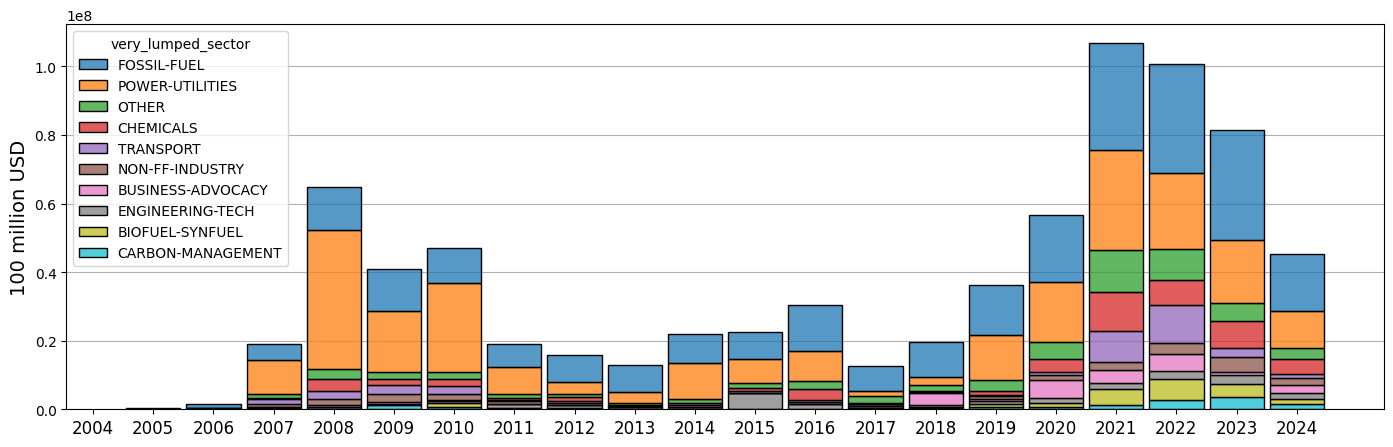

In [278]:
# for histogram hue ordering:
sector_for_group = "very_lumped_sector"
very_lumped_order = list(
    df[[sector_for_group, "lobbying_activity_usd"]]
    .groupby(sector_for_group)
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .index
)

# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", sector_for_group]]
    .loc[(df.definitely_ccs == 1)]
    .groupby([sector_for_group, "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue=sector_for_group,
    hue_order=very_lumped_order,
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
    palette="tab10",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")a

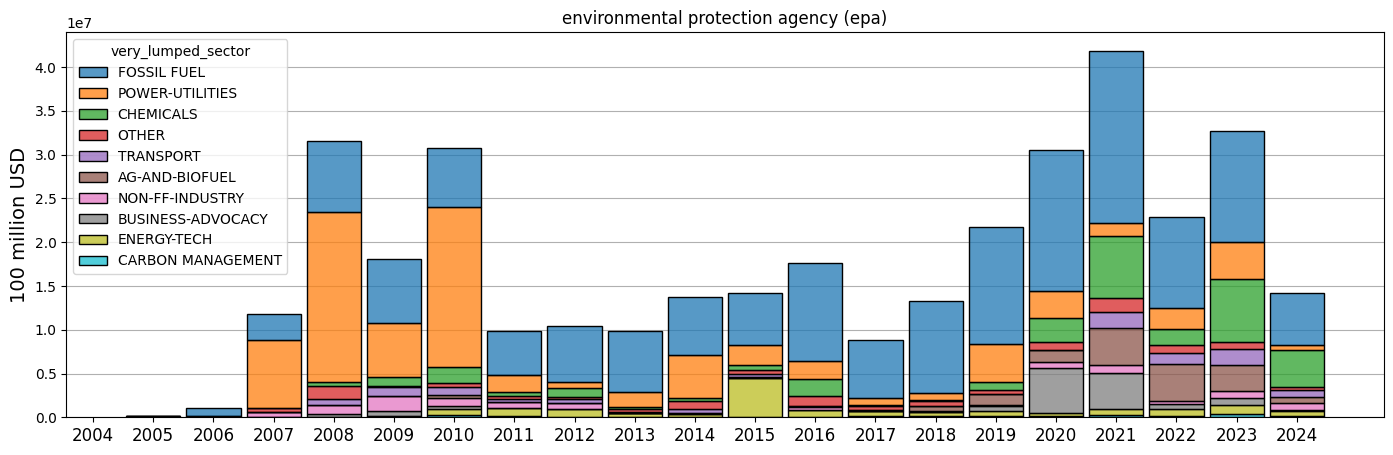

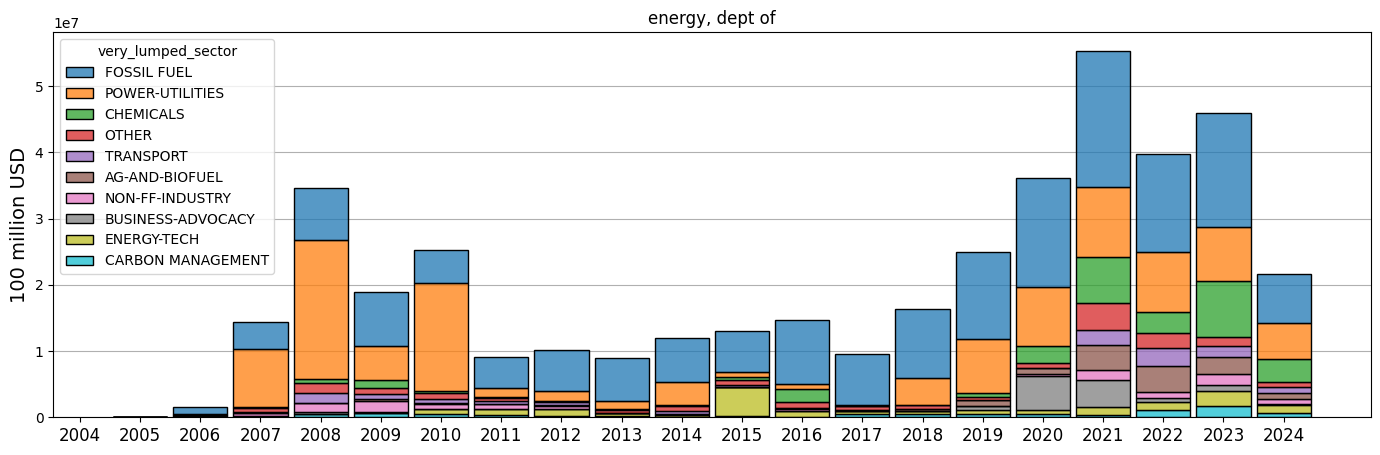

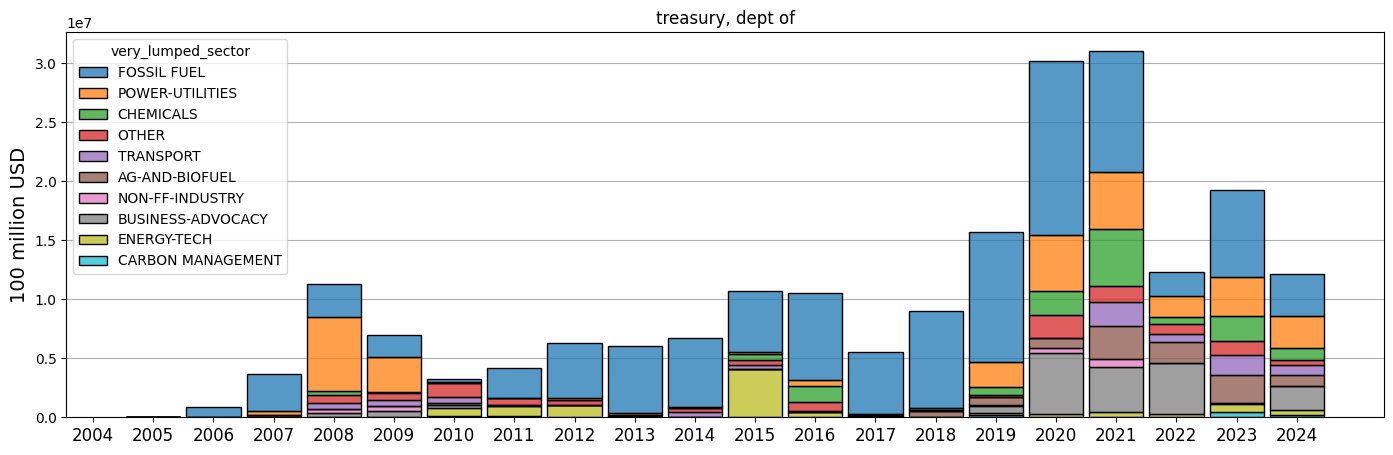

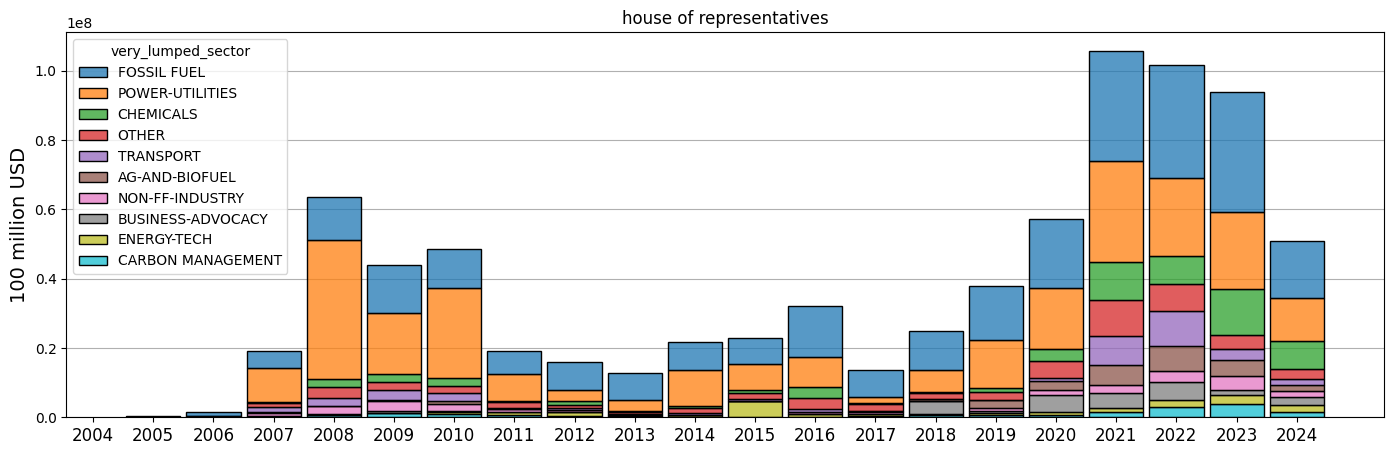

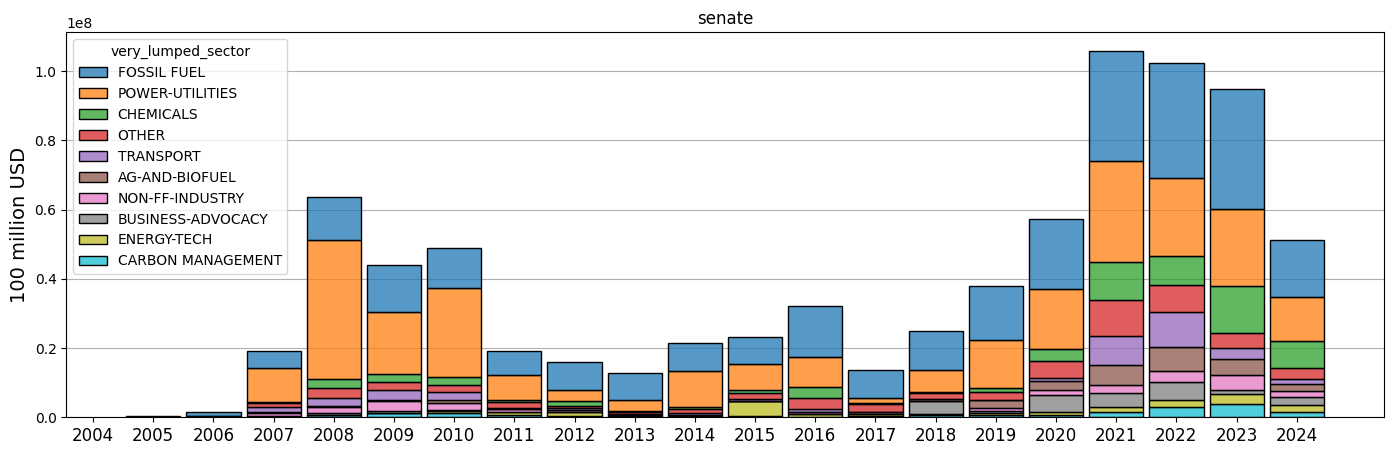

In [64]:
# lobbying_activity_usd
years = list(range(2004, 2025))
for agency in [
    "environmental protection agency (epa)",
    "energy, dept of",
    "treasury, dept of",
    "house of representatives",
    "senate",
]:
    tmp_df = (
        df[["filing_year", "lobbying_activity_usd", "very_lumped_sector"]]
        .loc[(df.very_likely_ccs == 1) & (df[agency] == 1)]
        .groupby(["very_lumped_sector", "filing_year"])
        .sum()
        .sort_values(by="lobbying_activity_usd", ascending=False)
        .reset_index()
    ).copy(deep=True)
    fig, ax = plt.subplots(1, 1, figsize=(17, 5))
    ax = sns.histplot(
        data=tmp_df,
        x="filing_year",
        bins=[0.5 + x for x in years],
        hue="very_lumped_sector",
        hue_order=very_lumped_order,
        shrink=0.9,
        weights="lobbying_activity_usd",
        multiple="stack",
    )
    ax.set_xticks(years)
    ax.set_xticklabels([str(x) for x in years], fontsize=12)
    ax.set_axisbelow(True)
    ax.yaxis.grid()
    ax.set_ylabel("100 million USD", fontsize=14)
    ax.set_xlabel("")
    ax.set_title(agency)
    # ax.legend(ncols=3, loc="upper center")a

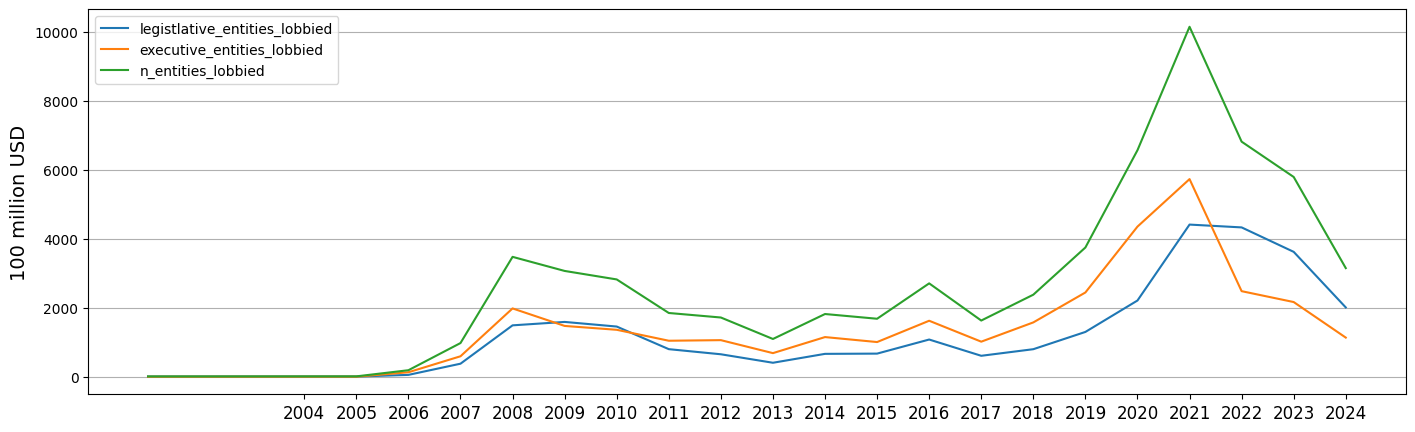

In [65]:
# lobbying_activity_usd
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
years = list(range(2004, 2025))

tmp_df = (
    df[
        [
            "filing_year",
            "legistlative_entities_lobbied",
            "executive_entities_lobbied",
            "n_entities_lobbied",
        ]
    ]
    .loc[(df.very_likely_ccs == 1)]
    .groupby(["filing_year"])
    .sum()
    .reset_index()
).copy(deep=True)

tmp_df = tmp_df.melt(id_vars="filing_year")
ax = sns.lineplot(
    data=tmp_df,
    x="filing_year",
    # bins=[0.5 + x for x in years],
    # hue="very_lumped_sector",
    # shrink=0.9,
    y="value",
    hue="variable"
    # multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
ax.legend()
# ax.legend(ncols=3, loc="upper center")a

Text(0.5, 0, '')

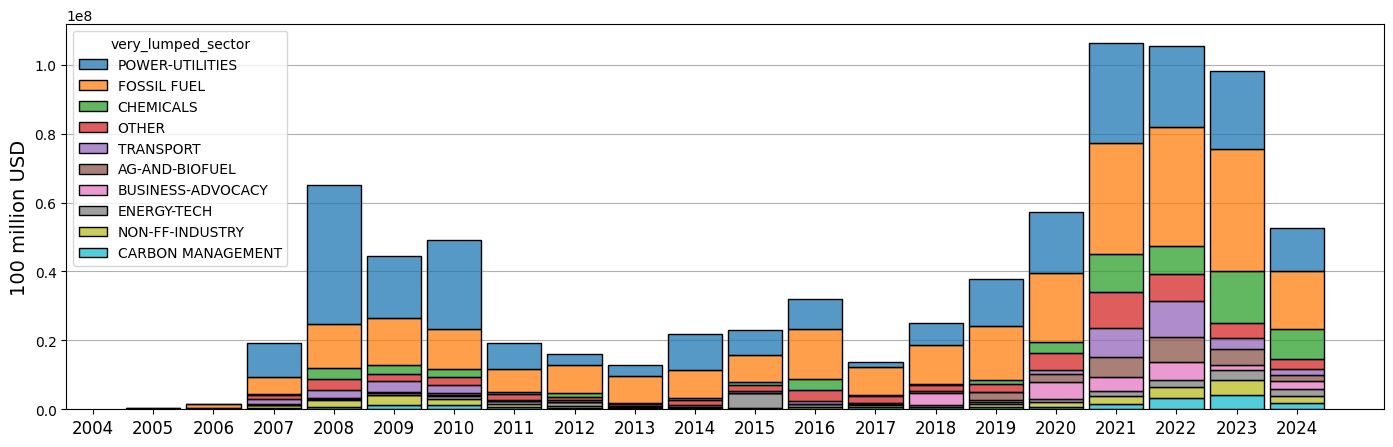

In [66]:
# lobbying_activity_usd
years = list(range(2004, 2025))

tmp_df = (
    df[["filing_year", "lobbying_activity_usd", "very_lumped_sector"]]
    .loc[(df.very_likely_ccs == 1)]  # & (cleaned_df.epa == 1)]
    .groupby(["very_lumped_sector", "filing_year"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
    .reset_index()
).copy(deep=True)
fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=tmp_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="very_lumped_sector",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("100 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")

Text(0.5, 0, '')

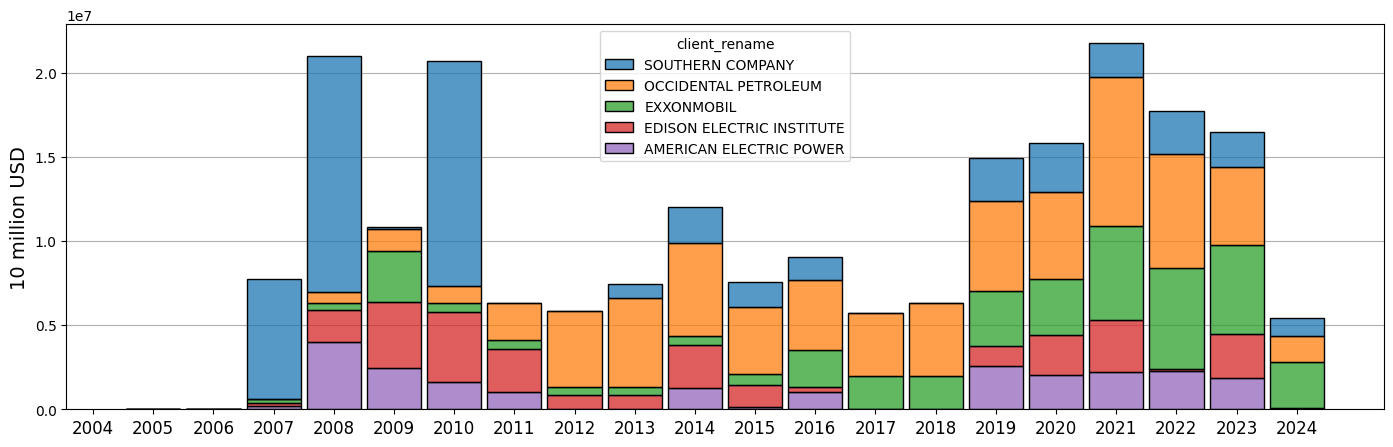

In [83]:
top_10 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
    "US CHAMBER OF COMMERCE",
    "SHELL",
    "DUKE",
    "BP AMERICA",
    "CHEVRON",
]
top_3 = ["EXXONMOBIL", "OCCIDENTAL PETROLEUM", "SOUTHERN COMPANY"]
top_5 = [
    "OCCIDENTAL PETROLEUM",
    "SOUTHERN COMPANY",
    "EXXONMOBIL",
    "EDISON ELECTRIC INSTITUTE",
    "AMERICAN ELECTRIC POWER",
]
top_df = (
    df[["lobbying_activity_usd", "n_entities_lobbied", "client_rename", "filing_year"]]
    .loc[(df.very_likely_ccs == 1) & (df.client_rename.isin(top_5))]
    .groupby(["filing_year", "client_rename"])
    .sum()
    .sort_values(by="lobbying_activity_usd", ascending=False)
)

years = list(range(2004, 2025))

fig, ax = plt.subplots(1, 1, figsize=(17, 5))
ax = sns.histplot(
    data=top_df,
    x="filing_year",
    bins=[0.5 + x for x in years],
    hue="client_rename",
    shrink=0.9,
    weights="lobbying_activity_usd",
    multiple="stack",
)
ax.set_xticks(years)
ax.set_xticklabels([str(x) for x in years], fontsize=12)
ax.set_axisbelow(True)
ax.yaxis.grid()
ax.set_ylabel("10 million USD", fontsize=14)
ax.set_xlabel("")
# ax.legend(ncols=3, loc="upper center")

In [ ]:
# top 50 pct companies chart
df[
    [
        "client_rename",
        "sector",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "pct_of_lobbying_dollars",
        "pct_of_entity_contacts",
    ]
].groupby(["client_rename"]).agg(
    {
        "lobbying_activity_usd": sum,
        "n_entities_lobbied": sum,
        "pct_of_lobbying_dollars": sum,
        "pct_of_entity_contacts": sum,
        "sector": "first",
    }
).sort_values(
    by="lobbying_activity_usd", ascending=False
).head(
    16
)  # .to_clipboard()

In [217]:
# top sectors chart
df[
    [
        "lumped_sector",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "pct_of_lobbying_dollars",
        "pct_of_entity_contacts",
    ]
].groupby(["lumped_sector"]).agg(
    {
        "lobbying_activity_usd": sum,
        "n_entities_lobbied": sum,
        "pct_of_lobbying_dollars": sum,
        "pct_of_entity_contacts": sum,
    }
).sort_values(
    by="lobbying_activity_usd", ascending=False
).to_clipboard()

In [ ]:
df[
    [
        "lumped_sector",
        "lobbying_activity_usd",
        "n_entities_lobbied",
        "pct_of_lobbying_dollars",
        "pct_of_entity_contacts",
    ]
].loc[(df.very_likely_ccs == 1) & (df.filing_year > 2018)].sum()

In [ ]:
27844 / (260 * 5.5)

In [87]:
df.groupby("client_rename").sum().to_clipboard()

In [89]:
df.columns.values

array(['filing_uuid', 'total_number_lobbying_activities',
       'total_number_of_lobbyists_on_filing', 'activity_id',
       'n_lobbyists_for_activity', 'filing_year', 'filing_period',
       'filing_dt_posted', 'which_congress', 'party_controlling_house',
       'party_controlling_senate', 'party_controlling_white_house',
       'filing_type', 'client_id', 'client_rename', 'client_name',
       'client_general_description', 'sector', 'lumped_sector',
       'very_lumped_sector', 'registrant_id', 'who_is_lobbying',
       'dollars_spent_lobbying', 'lobbying_activity_usd',
       'n_entities_lobbied', 'legistlative_entities_lobbied',
       'executive_entities_lobbied', 'affiliated_organizations_present',
       'definitely_ccs', 'very_likely_ccs', 'likely_ccs',
       'potentially_ccs', 'general_issue_code', 'description',
       'posted_by_name', 'registrant_name', 'registrant_contact_name',
       'client_state', 'client_ppb_state', 'client_country',
       'client_ppb_country', 'ur

In [95]:
def make_unique_list(x):
    return sorted(list(set(x)))

In [101]:
handling_dict = {
    "filing_uuid": make_unique_list,
    "n_lobbyists_for_activity": "sum",
    "filing_year": make_unique_list,
    "client_name": make_unique_list,
    #'client_general_description':'sum',
    "sector": "first",
    "lumped_sector": "first",
    "very_lumped_sector": "first",
    "lobbying_activity_usd": "sum",
    "n_entities_lobbied": "sum",
    "legistlative_entities_lobbied": "sum",
    "executive_entities_lobbied": "sum",
    "general_issue_code": make_unique_list,
    "pct_of_lobbying_dollars": "sum",
    "pct_of_entity_contacts": "sum",
} | dict(zip(entities, ["sum"] * len(entities)))

df.loc[df.likely_ccs == 1].groupby("client_rename").agg(handling_dict).to_clipboard()

In [98]:
entities = [
    "u.s. trade representative (ustr)",
    "u.s. coast guard (uscg)",
    "securities & exchange commission (sec)",
    "defense department field activities",
    "federal motor carrier safety administration",
    "labor, dept of (dol)",
    "health & human services, dept of (hhs)",
    "overseas private investment corp (opic)",
    "pension benefit guaranty corporation (pbgc)",
    "u.s. customs & border protection",
    "council on environmental quality (ceq)",
    "farm credit administration",
    "advisory council on historic preservation (achp)",
    "federal deposit insurance corporation (fdic)",
    "bureau of industry and security (bis)",
    "bureau of reclamation",
    "centers for disease control & prevention (cdc)",
    "commerce, dept of (doc)",
    "office of policy development",
    "u.s. chemical safety & hazard investigation board",
    "u.s. postal service (usps)",
    "defense information systems agency",
    "natl labor relations board (nlrb)",
    "natl park service (nps)",
    "u.s. agency for international development (usaid)",
    "u.s. copyright office",
    "office of juvenile justice & delinquency prevention",
    "office of the secretary of defense",
    "natl science foundation (nsf)",
    "minority business development agency",
    "tennessee valley authority (tva)",
    "federal reserve system",
    "federal election commission (fec)",
    "natl credit union administration (ncua)",
    "defense intelligence agency (dia)",
    "appalachian regional commission",
    "u.s. fish & wildlife service (usfws)",
    "executive office of the president (eop)",
    "defense security cooperation agency (dsca)",
    "food & drug administration (fda)",
    "natl endowment for the humanities",
    "general services administration (gsa)",
    "energy, dept of",
    "federal railroad administration",
    "natl institute of justice",
    "federal energy regulatory commission (ferc)",
    "defense commissary agency",
    "veterans affairs, dept of (va)",
    "council of economic advisers (cea)",
    "federal emergency management agency (fema)",
    "agency for healthcare research & quality (ahrq)",
    "air force, dept of",
    "railroad retirement board",
    "amtrak - natl railroad passenger corporation",
    "office of the vice president of the united states",
    "african development foundation",
    "natl guard",
    "minerals management service",
    "federal bureau of investigation (fbi)",
    "internal revenue service (irs)",
    "agriculture, dept of (usda)",
    "consumer product safety commission (cpsc)",
    "natl mediation board",
    "bureau of the census",
    "undetermined",
    "state, dept of (dos)",
    "natl security council (nsc)",
    "congressional budget office (cbo)",
    "employment & training administration",
    "federal aviation administration (faa)",
    "homeland security, dept of (dhs)",
    "health resources & services administration (hrsa)",
    "u.s. trade & development agency (ustda)",
    "library of congress (loc)",
    "defense logistics agency",
    "surface transportation board (stb)",
    "pension & welfare benefits administration",
    "economic development administration",
    "white house office",
    "natl institute of standards & technology (nist)",
    "bureau of citizenship & immigration services (bcis)",
    "vice president of the u.s.",
    "office of administration",
    "natl economic council (nec)",
    "natl aeronautics & space administration (nasa)",
    "small business administration (sba)",
    "financial crimes enforcement network (fincen)",
    "export-import bank of the united states (exim bank)",
    "navy, dept of",
    "office of surface mining reclamation & enforcement",
    "agency for toxic substances & disease registry",
    "patent & trademark office (pto)",
    "federal housing finance agency (fhfa)",
    "bureau of land management (blm)",
    "centers for medicare and medicaid services (cms)",
    "natl telecommunications & information administration (ntia)",
    "natl transportation safety board (ntsb)",
    "election assistance commission (eac)",
    "education, dept of",
    "treasury, dept of",
    "occupational safety & health administration (osha)",
    "u.s. immigration & customs enforcement (ice)",
    "government accountability office (gao)",
    "social security administration (ssa)",
    "natl institute of mental health (nimh)",
    "commodity futures trading commission (cftc)",
    "merit systems protection board",
    "marine mammal commission",
    "administration for children & families (acf)",
    "defense, dept of (dod)",
    "defense advanced research projects agency (darpa)",
    "substance abuse & mental health services administration (samhsa)",
    "natl indian gaming commission",
    "office of special counsel",
    "u.s. geological survey (usgs)",
    "bureau of labor statistics (bls)",
    "alcohol & tobacco tax & trade bureau (ttb)",
    "interior, dept of (doi)",
    "natl institutes of health (nih)",
    "drug enforcement administration (dea)",
    "federal transit administration (fta)",
    "mine safety & health administration (msha)",
    "maritime administration (marad)",
    "transportation security administration (tsa)",
    "office of personnel management (opm)",
    "u.s. forest service",
    "indian health service",
    "federal accounting standards advisory board (fasab)",
    "pipeline & hazardous materials safety administration",
    "bureau of indian affairs (bia)",
    "house of representatives",
    "natl oceanic & atmospheric administration (noaa)",
    "defense contract audit agency (dcaa)",
    "office of management & budget (omb)",
    "army, dept of (other)",
    "intl trade administration (ita)",
    "nuclear regulatory commission (nrc)",
    "defense finance & accounting service (dfas)",
    "st. lawrence seaway development corporation",
    "director of national intelligence (odni)",
    "housing & urban development, dept of (hud)",
    "u.s. architectural & transportation barriers compliance board (access)",
    "u.s. international trade commission (itc)",
    "veterans employment & training service",
    "u.s. marines",
    "federal communications commission (fcc)",
    "natl security agency (nsa)",
    "natl highway traffic safety administration (nhtsa)",
    "federal trade commission (ftc)",
    "equal employment opportunity commission (eeoc)",
    "office of science & technology policy (ostp)",
    "postal regulatory commission",
    "senate",
    "transportation, dept of (dot)",
    "federal maritime commission",
    "environmental protection agency (epa)",
    "office of the comptroller of the currency (occ)",
    "consumer financial protection bureau (cfpb)",
    "army, dept of (corps of engineers)",
    "federal highway administration (fha)",
    "justice, dept of (doj)",
    "president of the u.s.",
    "federal mediation & conciliation service",
    "risk management agency",
    "u.s. information agency (usia)",
]

{'u.s. trade representative (ustr)': 'sum',
 'u.s. coast guard (uscg)': 'sum',
 'securities & exchange commission (sec)': 'sum',
 'defense department field activities': 'sum',
 'federal motor carrier safety administration': 'sum',
 'labor, dept of (dol)': 'sum',
 'health & human services, dept of (hhs)': 'sum',
 'overseas private investment corp (opic)': 'sum',
 'pension benefit guaranty corporation (pbgc)': 'sum',
 'u.s. customs & border protection': 'sum',
 'council on environmental quality (ceq)': 'sum',
 'farm credit administration': 'sum',
 'advisory council on historic preservation (achp)': 'sum',
 'federal deposit insurance corporation (fdic)': 'sum',
 'bureau of industry and security (bis)': 'sum',
 'bureau of reclamation': 'sum',
 'centers for disease control & prevention (cdc)': 'sum',
 'commerce, dept of (doc)': 'sum',
 'office of policy development': 'sum',
 'u.s. chemical safety & hazard investigation board': 'sum',
 'u.s. postal service (usps)': 'sum',
 'defense informati